# Identify tissue/cancer associated proteins from DIA quants

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import sklearn.preprocessing as pre
import warnings
import scipy.stats
warnings.filterwarnings("ignore")

### Cancer cell line DIA data analysis

In [2]:
data=pd.read_csv('CCLE_2022_proteinquant.csv',index_col=0)
data=data.drop(columns="Q96Q83;ALKB3_HUMAN")
tissue=pd.read_csv('CCLE_Project_tissues.csv')

data=data.fillna(value=dict(data.min()-0.1))
data=round(data,2)

selected=tissue[['Project_Identifier','Cell_line','Tissue_type','Gender','Source','Cancer_type',"media"]]
protein_quant_tissue=pd.merge(data,selected,left_index=True,right_on='Project_Identifier')

protein_quant_melt=pd.melt(protein_quant_tissue,id_vars=["Cell_line","Tissue_type","Gender","media"])
protein_quant_melt["Gene"]=protein_quant_melt['variable'].str.split(';').str[1].str.replace('_HUMAN','')

protein_quant_melt=protein_quant_melt.dropna(subset=['Gene'])
#protein_quant_melt[['Cell_line','Tissue_type','Gene','value']].to_csv("Protein_quant_melt.csv",index=False)

In [3]:

def plot_tissue_boxplot(df,gene):
    gene=gene.upper()
    sel=df[df['Gene']==gene]
    sel=sel.sort_values(by="Tissue_type")
    sns.catplot(sel,x="Tissue_type",y="value",kind='box',boxprops=dict(alpha=0.3),height=6,aspect=1.5)
    sns.stripplot(sel,x="Tissue_type",y="value",alpha=0.6,hue="Tissue_type",legend=False)
    plt.xticks(rotation=90)
    plt.ylabel("Protein quant-log2")
    plt.title("Protein quant CCLE data - cell lines grouped by tissue type")
    plt.show()

def plot_gender_boxplot(df,gene):
    gene=gene.upper()
    sel=df[df['Gene']==gene]
    sns.catplot(sel,x="Gender",y="value",kind='box',boxprops=dict(alpha=0.3),height=3,aspect=1)
    sns.stripplot(sel,x="Gender",y="value",alpha=0.3,hue="Gender",legend=False)
    plt.xticks(rotation=90)
    plt.ylabel("Protein quant-log2")
    plt.title("Protein quant CCLE data - cell lines grouped by Gender")
    plt.show()

def plot_source_boxplot(df,gene):
    gene=gene.upper()
    sel=df[df['Gene']==gene]
    sns.boxplot(sel,x="media",y="value")
    sns.stripplot(sel,x="media",y="value")
    plt.xticks(rotation=90)
    plt.title("Protein quant CCLE data - cell lines grouped by media")
    plt.show()


### Number of cell lines per tissue type

Text(0.5, 1.0, 'CCLE data: 949 cancer cell-lines from diverse tissue types')

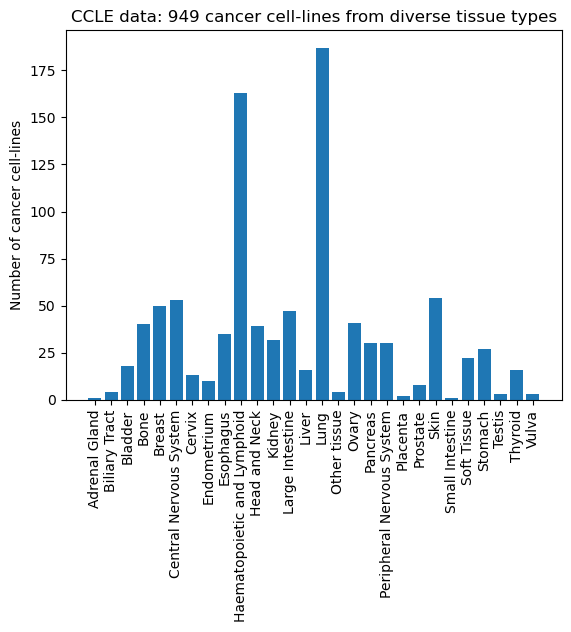

In [5]:
data1=pd.read_csv('CCLE_2022_proteinquant.csv',index_col=0)
data1=data1.drop(columns="Q96Q83;ALKB3_HUMAN")
tissue1=pd.read_csv('CCLE_Project_tissues.csv')

selected1=tissue1[['Project_Identifier','Tissue_type',"Gender"]]
protein_tissue=pd.merge(data1,selected1,left_index=True,right_on='Project_Identifier')
cc_count=protein_tissue.groupby('Tissue_type')['Project_Identifier'].count()
plt.bar(x=cc_count.index,height=cc_count)
plt.xticks(rotation=90)
plt.ylabel("Number of cancer cell-lines")
plt.title("CCLE data: 949 cancer cell-lines from diverse tissue types")

### Protein identification per tissue type

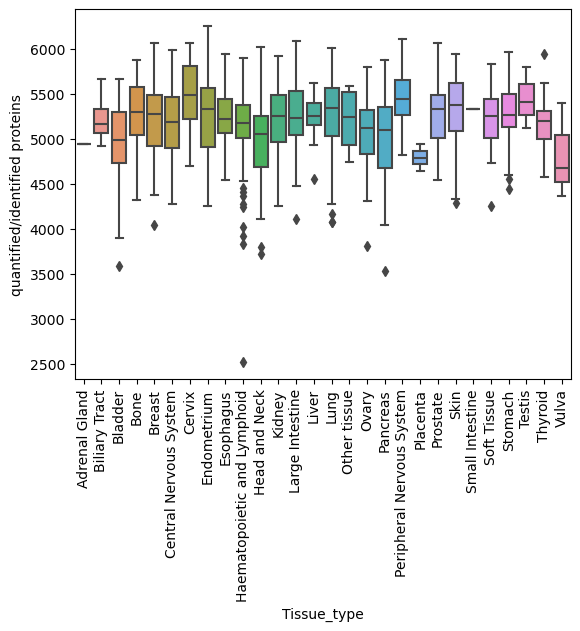

In [6]:
#cc_count=protein_tissue.groupby('Tissue_type')['Project_Identifier'].count()
protein_tissue_melt=pd.melt(protein_tissue,id_vars=['Project_Identifier',"Tissue_type"])
potein_quantified=protein_tissue_melt.dropna().groupby(["Tissue_type",'Project_Identifier'],as_index=False)['variable'].nunique()
sns.boxplot(potein_quantified,x="Tissue_type",y="variable")
#sns.stripplot(potein_quantified,x="Tissue_type",y="variable")
plt.xticks(rotation=90)
plt.ylabel("quantified/identified proteins")
plt.show()

### Differentially abundant proteins

### Lung vs other tissue comparison

Text(0.5, 1.0, 'Differentially abundant proteins Lung vs other')

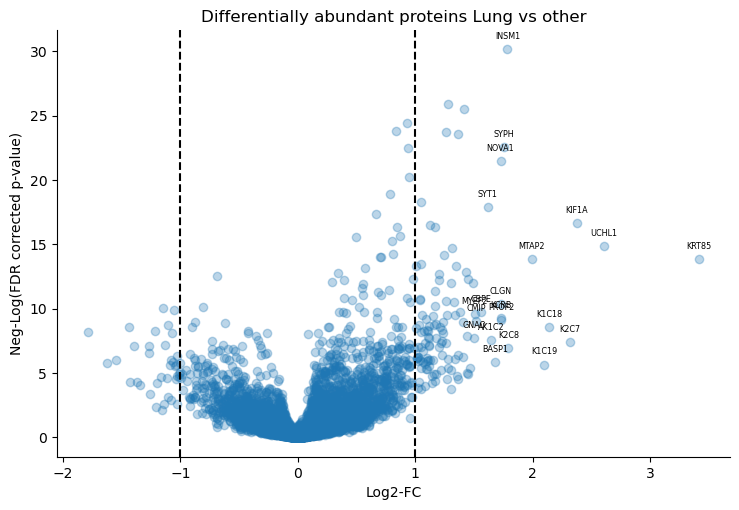

In [9]:
protein_quant_tissue.index=protein_quant_tissue['Project_Identifier']
#['Project_Identifier','Cell_line','Tissue_type','Gender','Source','Cancer_type','media']
data_df_lung=protein_quant_tissue[protein_quant_tissue['Tissue_type']=='Lung']
data_df_lung=data_df_lung.drop(columns=['Project_Identifier','Cell_line','Tissue_type',
                                        'Gender','Source','Cancer_type','media'])
data_df_other=protein_quant_tissue[~(protein_quant_tissue['Tissue_type']=='Lung')]
data_df_other=data_df_other.drop(columns=['Project_Identifier','Cell_line','Tissue_type',
                                        'Gender','Source','Cancer_type','media'])

tres=scipy.stats.ttest_ind(data_df_lung, data_df_other, axis=0)
tres_df=pd.DataFrame(tres,columns=data_df_lung.columns,index=['t-stats','p-value']).T
from statsmodels.stats.multitest import multipletests
tres_df["fdr_bh"]=multipletests(tres_df["p-value"], method = "fdr_bh")[1]
tres_df["neg_log"]=np.log10(tres_df["fdr_bh"])*-1
tres_df["lung_mean"]=data_df_lung.mean()
tres_df["other_mean"]=data_df_other.mean()
tres_df["FC"]=tres_df["lung_mean"]-tres_df["other_mean"]
tres_df["Gene"]=tres_df.index.str.split(';').str[1].str.replace('_HUMAN','')
sns.lmplot(tres_df,x="FC",y="neg_log",fit_reg=False,scatter_kws={'alpha':0.3},height=5,aspect=1.5)

plt.axvline(-1,linestyle="--",color='black')
plt.axvline(1,linestyle="--",color='black')

tres_df_sig=tres_df[(tres_df["FC"]>=1.5)]

texts = [plt.text(tres_df_sig.iloc[i,6], tres_df_sig.iloc[i,3]+1, 
                  tres_df_sig.iloc[i,7], ha='center', va='center',size='xx-small')\
         for i in range(tres_df_sig.shape[0])]
plt.xlabel("Log2-FC")
plt.ylabel("Neg-Log(FDR corrected p-value)")
plt.title("Differentially abundant proteins Lung vs other")

### Multivariate linear regression to identify biases and to find out which of the differential proteins
### are due to some Bias in attributes of the cell lines other than tissue

In [10]:
x=tissue[['Project_Identifier','ploidy', 'mutational_burden']]
tissue_type=pd.get_dummies(tissue['Tissue_type'], dtype=int)
tissue_type=tissue_type[["Lung"]]
gender=pd.get_dummies(tissue['Gender'], dtype=int).drop(columns='Unknown')
msi=pd.get_dummies(tissue['msi_status'], dtype=int)
growth=pd.get_dummies(tissue['growth_properties'], dtype=int)
media=pd.get_dummies(tissue['media'], dtype=int)
x=pd.concat([x,gender,growth,media,msi],axis=1)

x.index=x['Project_Identifier']
x=x.drop(columns=['Project_Identifier',"Unknown","Female","R","MSI"])
x=x.rename(columns={'Male':'Gender','D/F12':'media','MSS':'MicroSatellite stability'})
x=x.dropna()

y=data
y=y.loc[x.index,:]
n_x=(x-x.min())/(x.max()-x.min())
X = sm.add_constant(n_x)

In [11]:
coef_dict=dict()
pval_dict=dict()
pred_dict=dict()

for i in y:
    y1=y[i]
    model = sm.OLS(y1, X).fit()
    coef_dict[i]=model.params
    pval_dict[i]=model.pvalues
    pred_dict[i]=model.predict()

coef_df=pd.DataFrame.from_dict(coef_dict)
pval_df=pd.DataFrame.from_dict(pval_dict)
pred_df=pd.DataFrame.from_dict(pred_dict)
sig_coef=coef_df[pval_df<0.05].T
sig_coef["Gene"]=sig_coef.index.str.split(';').str[1]
pred_df.index=X.index
residuals=y-pred_df

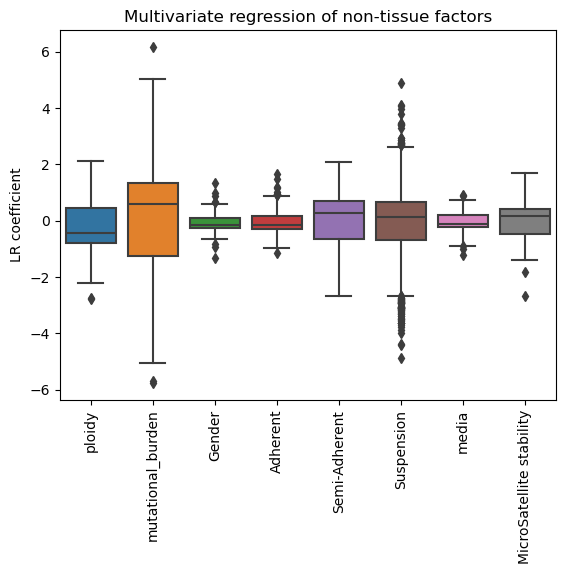

In [12]:
sig_coef=sig_coef.drop(columns="const")
sns.boxplot(sig_coef)
plt.xticks(rotation=90)
plt.ylabel("LR coefficient")
plt.title("Multivariate regression of non-tissue factors")
plt.show()

### Top genes associated with gender
### KIF1A and UCHL1 are among the gender associated proteins that were among the differential proteins for lung tissue

Text(0.5, 0, 'Gender-Association')

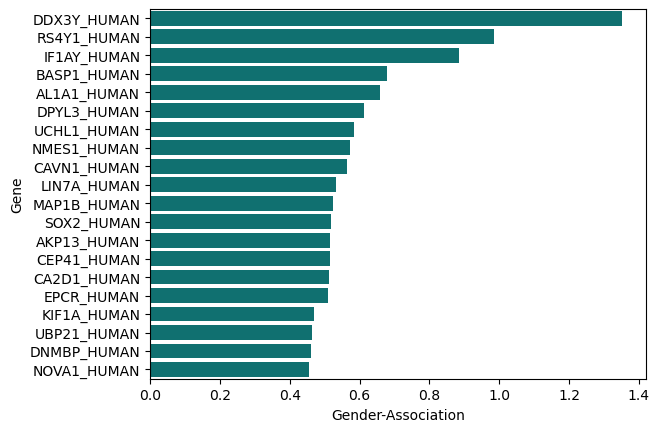

In [13]:
gender_associated=sig_coef.sort_values(by="Gender",ascending=False).head(20)
sns.barplot(gender_associated,y="Gene",x="Gender",color="teal")
plt.xlabel("Gender-Association")

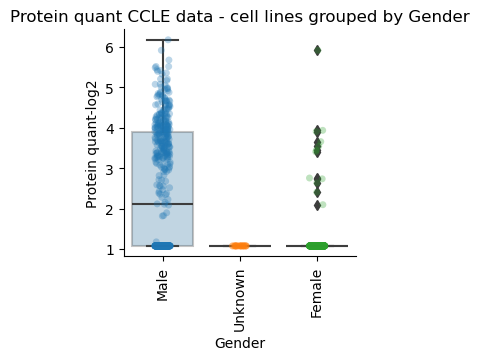

In [14]:
gene="DDX3Y"
plot_gender_boxplot(protein_quant_melt,gene)

Text(0.5, 1.0, 'CCLE data: 949 cancer cell-lines from diverse tissue types')

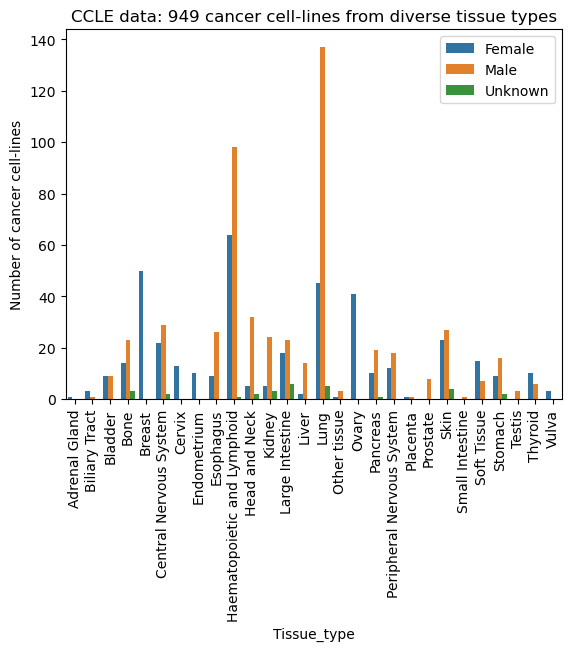

In [15]:
gender_count=protein_tissue.groupby(['Tissue_type','Gender'],as_index=False)['Project_Identifier'].count()
ax=sns.barplot(gender_count,x='Tissue_type',y='Project_Identifier',hue='Gender')
plt.xticks(rotation=90)
plt.ylabel("Number of cancer cell-lines")
ax.legend(loc='upper right')
plt.title("CCLE data: 949 cancer cell-lines from diverse tissue types")

### some of the gender associated proteins come up as differential for lung tissue 
### due to higher number of male cell lines for lung tissue 

In [16]:
selected=tissue[['Project_Identifier','Cell_line','Tissue_type','Gender','Source','Cancer_type',"media"]]
residual_tissue=pd.merge(residuals,selected,left_index=True,right_on='Project_Identifier')
residual_tissue_melt=pd.melt(residual_tissue,id_vars=["Cell_line","Tissue_type","Gender","media"])
residual_tissue_melt["Gene"]=residual_tissue_melt['variable'].str.split(';').str[1].str.replace('_HUMAN','')
residual_tissue_melt=residual_tissue_melt.dropna(subset=['Gene'])

## Logistic regression

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

tissue_type=pd.get_dummies(tissue['Tissue_type'], dtype=int)
tissue_type=tissue_type[["Lung"]]
tissue_type.index=tissue["Project_Identifier"]
tissue_type=tissue_type.loc[residuals.index,:]
y_LR=tissue_type.values.ravel()


In [18]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_auc_score ,roc_curve,auc
import sklearn.metrics as metrics
from sklearn.utils.class_weight import compute_sample_weight

clf=LogisticRegression(solver='liblinear',C=0.1,penalty="l1",class_weight="balanced")
sc = StandardScaler()
logreg_coef_df=pd.DataFrame()
skf = StratifiedKFold(n_splits=5,shuffle=False)
X1=residuals
y=y_LR
X = pd.DataFrame(sc.fit_transform(X1),index=X1.index,columns=X1.columns)
y_preds=[]
y_tests=[]
f=0
for train_index, test_index in skf.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf.fit(X_train,y_train)
    score = roc_auc_score(y_test,clf.predict(X_test))
    #print('ROC AUC score:',score)
    y_tests.extend(y_test)
    y_preds.extend(clf.predict_proba(X_test)[:,1])
    #print(len(clf.coef_[0]))
    logreg_coef_df=pd.concat([logreg_coef_df,pd.DataFrame(clf.coef_[0],index=X.columns,columns=[f])],axis=1)
    f=f+1
balanced_sample_weights=compute_sample_weight(class_weight='balanced', y=y_tests)
fpr, tpr, threshold = metrics.roc_curve(y_tests, y_preds,sample_weight=balanced_sample_weights)
roc_auc = metrics.auc(fpr, tpr)

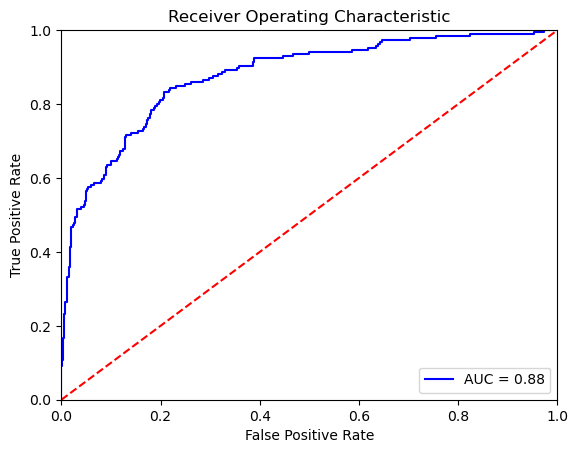

In [19]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()



### Top proteins contributing to the classification model 

Text(0.5, 0, 'Lung-Association')

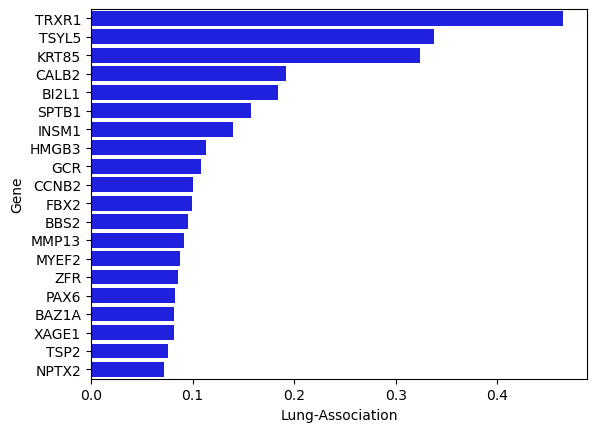

In [20]:
#logreg_coef_df_avg=logreg_coef_df.mean(axis=1
logreg_coef_df['Avg']=logreg_coef_df.mean(axis=1)
logreg_coef_df=logreg_coef_df.sort_values(by="Avg",ascending=False)
logreg_coef_df["Gene"]=logreg_coef_df.index.str.split(';').str[1].str.replace('_HUMAN','')
sns.barplot(logreg_coef_df.head(20),x="Avg",y="Gene",color="blue",orient="h")
plt.xlabel("Lung-Association")

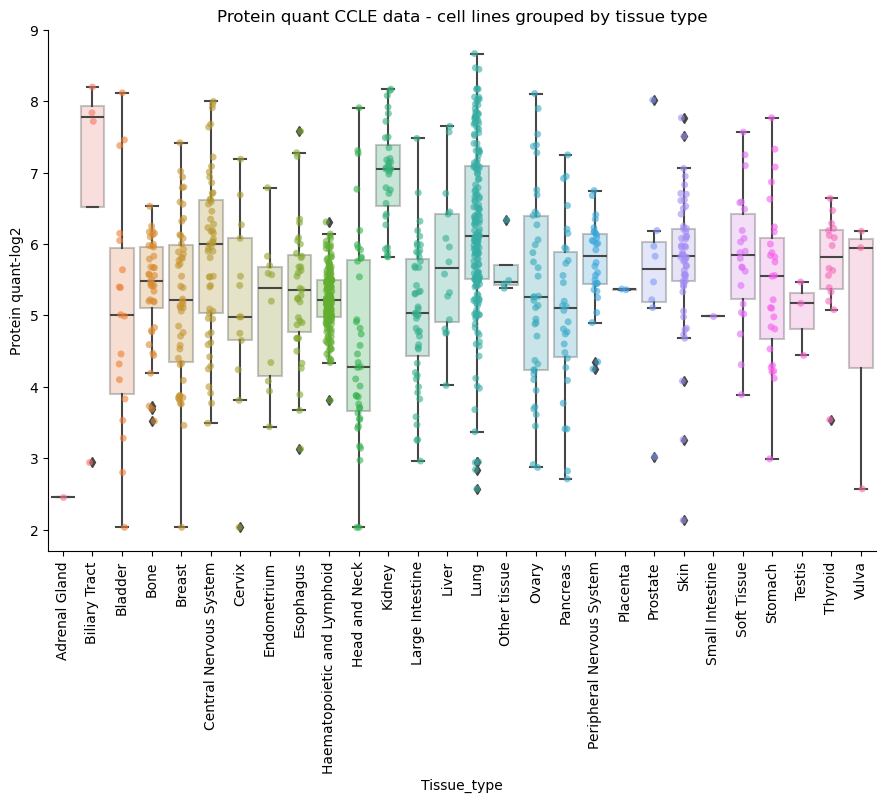

In [21]:
gene="TRXR1"
plot_tissue_boxplot(protein_quant_melt,gene)